<a href="https://colab.research.google.com/github/ogulcangul07/Nba22-23_Salary_Prediction/blob/main/Nba22/23_Salary_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Gerekli kütüphanelerin import edilmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [43]:
data=pd.read_csv('/content/nba_salary.csv')

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
plt.style.use('default')

**Veri Keşfi**

In [45]:
# Veri setini inceleme fonksiyonu
def check_df(dataframe):
    print(dataframe.shape)
    print("############################################")
    print(dataframe.info())
    print("############################################")
    print(dataframe.nunique())
    print("############################################")
    print(dataframe.isnull().sum())
check_df(data)
# Maaş dağılımının istatistikleri
quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
data['Salary'].describe(quantiles).T

(467, 30)
############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Index        467 non-null    int64  
 1   Player Name  467 non-null    object 
 2   Team         467 non-null    object 
 3   Salary       467 non-null    int64  
 4   Position     467 non-null    object 
 5   Age          467 non-null    int64  
 6   GP           467 non-null    int64  
 7   MP           467 non-null    float64
 8   FG           467 non-null    float64
 9   FG%          467 non-null    float64
 10  3P           467 non-null    float64
 11  3P%          467 non-null    float64
 12  2P           467 non-null    float64
 13  2P%          467 non-null    float64
 14  eFG%         467 non-null    float64
 15  FT           467 non-null    float64
 16  FT%          467 non-null    float64
 17  TRB          467 non-null    float64


,Salary
count,467.000
mean,8416598.747
std,10708118.047
min,5849.000
5%,192513.200
10%,508891.000
20%,1563518.000
30%,1960676.200
40%,2520624.000
50%,3722040.000


In [46]:
data.head(5)

,Index,Player Name,Team,Salary,Position,Age,GP,MP,FG,FG%,3P,3P%,2P,2P%,eFG%,FT,FT%,TRB,AST,STL,BLK,TOV,FOUL,PTS,PER,TS%,USG%,WS,BPM,VORP
0,0,Stephen Curry,GSW,48070014,PG,34,56,34.700,10.000,0.493,4.900,0.427,5.100,0.579,0.614,4.600,0.915,6.100,6.300,0.900,0.400,3.200,2.100,29.400,24.100,0.656,31.000,7.800,7.500,4.700
1,1,John Wall,LAC,47345760,PG,32,34,22.200,4.100,0.408,1.000,0.303,3.100,0.459,0.457,2.300,0.681,2.700,5.200,0.800,0.400,2.400,1.700,11.400,13.600,0.498,27.000,0.300,-1.200,0.100
2,2,Russell Westbrook,LAL/LAC,47080179,PG,34,73,29.100,5.900,0.436,1.200,0.311,4.700,0.487,0.481,2.800,0.656,5.800,7.500,1.000,0.500,3.500,2.200,15.900,16.100,0.513,27.700,1.900,0.200,1.200
3,3,LeBron James,LAL,44474988,PF,38,55,35.500,11.100,0.500,2.200,0.321,8.900,0.580,0.549,4.600,0.768,8.300,6.800,0.900,0.600,3.200,1.600,28.900,23.900,0.583,33.300,5.600,6.100,4.000
4,4,Kevin Durant,BRK/PHO,44119845,PF,34,47,35.600,10.300,0.560,2.000,0.404,8.300,0.617,0.614,6.500,0.919,6.700,5.000,0.700,1.400,3.300,2.100,29.100,25.900,0.677,30.700,6.800,7.100,3.900


**Veri Ön İşleme**

In [47]:
data["Position"].unique()

array(['PG', 'PF', 'SG', 'SF', 'PG-SG', 'C', 'SF-SG', 'SG-PG', 'SF-PF'],
      dtype=object)

In [48]:
data["Position"]=data["Position"].str.split('-').str[0]
data["Position"].unique()

array(['PG', 'PF', 'SG', 'SF', 'C'], dtype=object)

Açıklama: Pozisyon bilgisi oyuncunun birincil poziyonu baz alınarak standartlaştırılıyor (örneğin "PG-SG" -> "PG")


In [49]:
data["Salary"]=round(data["Salary"]/1000000,2)
data.rename(columns={'Salary':'Salary_Million'},inplace=True)
data['Salary_Million'].describe().T

,Salary_Million
count,467.000
mean,8.417
std,10.708
min,0.010
25%,1.780
50%,3.720
75%,10.630
max,48.070


Açıklama: Maaş verilerinin okunabilirliğini artırmak amacıyla, tutarlar milyon birimine dönüştürülüyor.

In [50]:
#Aykırı Değerleri Temizleme
minimum_salary=1 # Nba'de yaklaşık minimum maaş(Altındaki değerler kısa süreli oynayan oyunculara ait)
data = data[(data['Salary_Million'] >= minimum_salary) & (data['GP'] >= 20)]
data.shape

(365, 30)

**Keşifçi Veri Analizi (EDA)**

**Maç Başına Efficeny Rating Top 10**

In [51]:
efficency_rating=data.sort_values(by='PER',ascending=False)
efficency_rating[['Player Name','Salary_Million','GP','PER']].head(10)

,Player Name,Salary_Million,GP,PER
27,Joel Embiid,33.620,66,31.400
8,Giannis Antetokounmpo,42.490,63,29.000
14,Anthony Davis,37.980,56,27.800
15,Jimmy Butler,37.650,64,27.600
34,Shai Gilgeous-Alexander,30.910,68,27.200
9,Damian Lillard,42.490,58,26.700
4,Kevin Durant,44.120,47,25.900
94,Zion Williamson,13.530,29,25.200
0,Stephen Curry,48.070,56,24.100
6,Kawhi Leonard,42.490,52,23.900


**Maç Başına Sayı Top 10**

In [52]:
point=data.sort_values(by='PTS',ascending=False)
point[['Player Name','Salary_Million','GP','PTS']].head(10)

,Player Name,Salary_Million,GP,PTS
27,Joel Embiid,33.620,66,33.100
9,Damian Lillard,42.490,58,32.200
34,Shai Gilgeous-Alexander,30.910,68,31.400
8,Giannis Antetokounmpo,42.490,63,31.100
37,Jayson Tatum,30.350,74,30.100
0,Stephen Curry,48.070,56,29.400
4,Kevin Durant,44.120,47,29.100
3,LeBron James,44.470,55,28.900
33,Donovan Mitchell,30.910,68,28.300
25,Devin Booker,33.830,53,27.800


**Maç Başına Asist Top 10**

In [53]:
asist=data.sort_values(by='AST',ascending=False)
asist[['Player Name','Salary_Million','GP','AST']].head(10)

,Player Name,Salary_Million,GP,AST
29,James Harden,33.000,58,10.700
216,Tyrese Haliburton,4.220,56,10.400
18,Trae Young,37.100,73,10.200
42,Chris Paul,28.400,59,8.900
142,LaMelo Ball,8.620,36,8.400
104,Ja Morant,12.120,61,8.100
137,Darius Garland,8.920,69,7.800
2,Russell Westbrook,47.080,73,7.500
23,Jrue Holiday,34.320,67,7.400
56,Domantas Sabonis,21.100,79,7.300


**Maç Başına Ribaund Top 10**

In [54]:
rebound=data.sort_values(by='TRB',ascending=False)
rebound[['Player Name','Salary_Million','GP','TRB']].head(10)

,Player Name,Salary_Million,GP,TRB
14,Anthony Davis,37.980,56,12.500
56,Domantas Sabonis,21.100,79,12.300
8,Giannis Antetokounmpo,42.490,63,11.800
12,Rudy Gobert,38.170,70,11.600
69,Steven Adams,17.930,42,11.500
67,Clint Capela,18.210,65,11.000
27,Joel Embiid,33.620,66,10.200
48,Julius Randle,23.760,77,10.000
35,Deandre Ayton,30.910,67,10.000
121,Ivica Zubac,10.120,76,9.900


**Maç Başına Top Kaybı Top 10**

In [55]:
turnover=data.sort_values(by='TOV',ascending=False)
turnover[['Player Name','Salary_Million','GP','TOV']].head(10)

,Player Name,Salary_Million,GP,TOV
18,Trae Young,37.100,73,4.100
8,Giannis Antetokounmpo,42.490,63,3.900
142,LaMelo Ball,8.620,36,3.600
2,Russell Westbrook,47.080,73,3.500
27,Joel Embiid,33.620,66,3.400
29,James Harden,33.000,58,3.400
104,Ja Morant,12.120,61,3.400
94,Zion Williamson,13.530,29,3.400
9,Damian Lillard,42.490,58,3.300
115,Anthony Edwards,10.730,79,3.300


<Axes: >

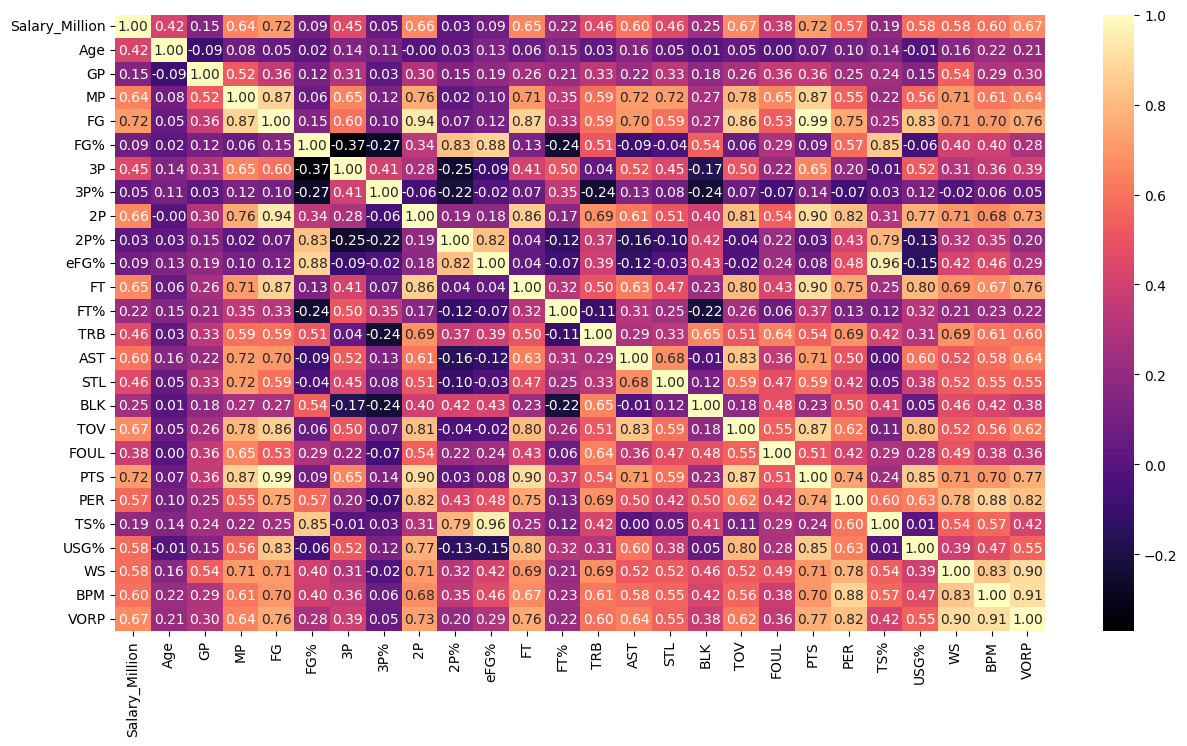

In [56]:
# Veri setindeki sayısal değişkenlerin korelasyon analizi
heat = data.select_dtypes(include=np.number)
heat.drop('Index',axis=1,inplace=True)
corelation=heat.corr()
f, ax = plt.subplots(figsize=[15, 8])
sns.heatmap(corelation,annot=True, fmt=".2f",ax=ax,cmap="magma")

Açıklama: Tüm sayısal değişkenler arasındaki korelasyonlar heatmap ile görselleştiriliyor. Bu,  istatistiklerin birbirleriyle olan ilişkisini gösteriyor.

count   365.000
mean     58.742
std      15.948
min      20.000
5%       29.200
10%      35.400
20%      42.000
30%      50.200
40%      56.600
50%      62.000
60%      66.400
70%      69.000
80%      74.000
90%      78.000
95%      80.000
99%      82.000
100%     83.000
max      83.000
Name: GP, dtype: float64


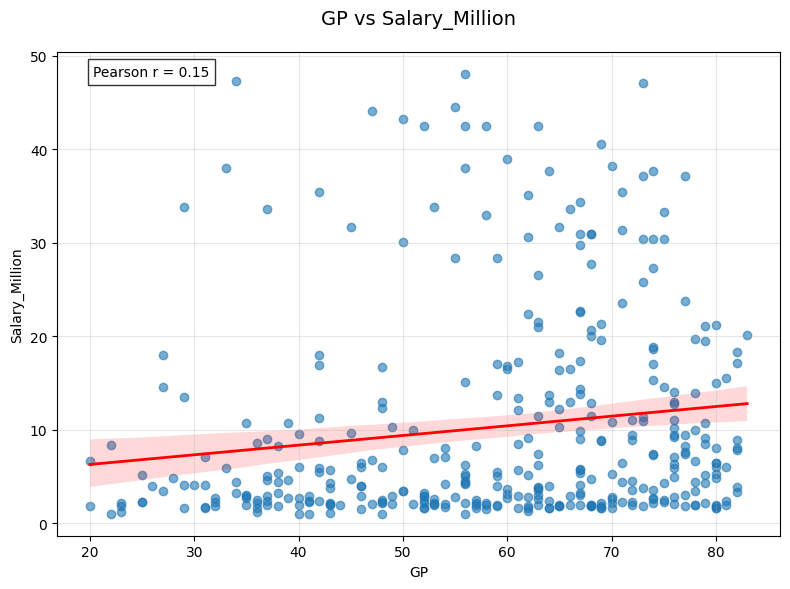

count   365.000
mean     22.402
std       8.481
min       4.700
5%        8.500
10%      11.380
20%      14.460
30%      16.700
40%      19.400
50%      21.900
60%      24.980
70%      28.400
80%      31.220
90%      34.400
95%      35.500
99%      36.736
100%     37.400
max      37.400
Name: MP, dtype: float64


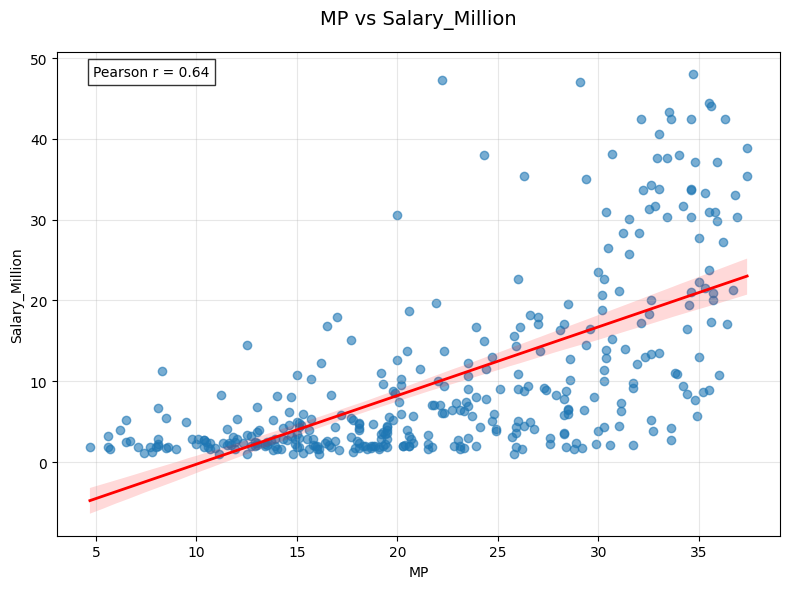

count   365.000
mean      3.970
std       2.263
min       0.400
5%        1.300
10%       1.600
20%       2.200
30%       2.600
40%       3.000
50%       3.500
60%       4.100
70%       4.500
80%       5.500
90%       6.960
95%       8.880
99%      11.536
100%     12.500
max      12.500
Name: TRB, dtype: float64


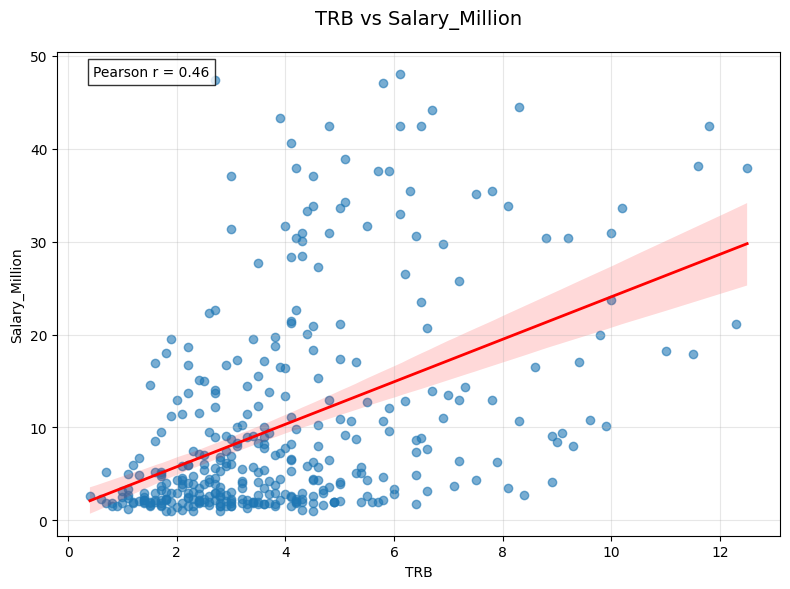

count   365.000
mean      2.401
std       1.971
min       0.200
5%        0.500
10%       0.600
20%       0.900
30%       1.100
40%       1.300
50%       1.600
60%       2.300
70%       2.900
80%       3.800
90%       5.360
95%       6.280
99%       8.580
100%     10.700
max      10.700
Name: AST, dtype: float64


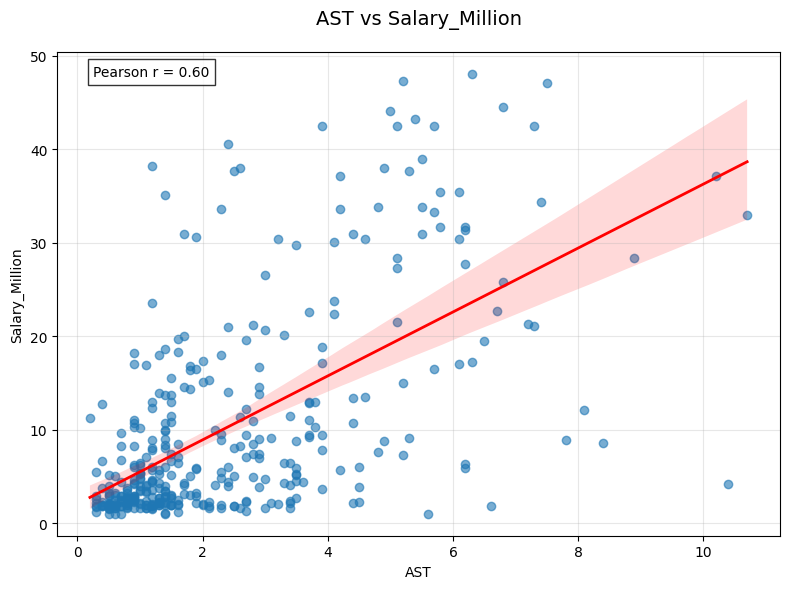

count   365.000
mean      1.266
std       0.811
min       0.100
5%        0.320
10%       0.500
20%       0.600
30%       0.700
40%       0.900
50%       1.000
60%       1.200
70%       1.500
80%       1.900
90%       2.500
95%       3.000
99%       3.436
100%      4.100
max       4.100
Name: TOV, dtype: float64


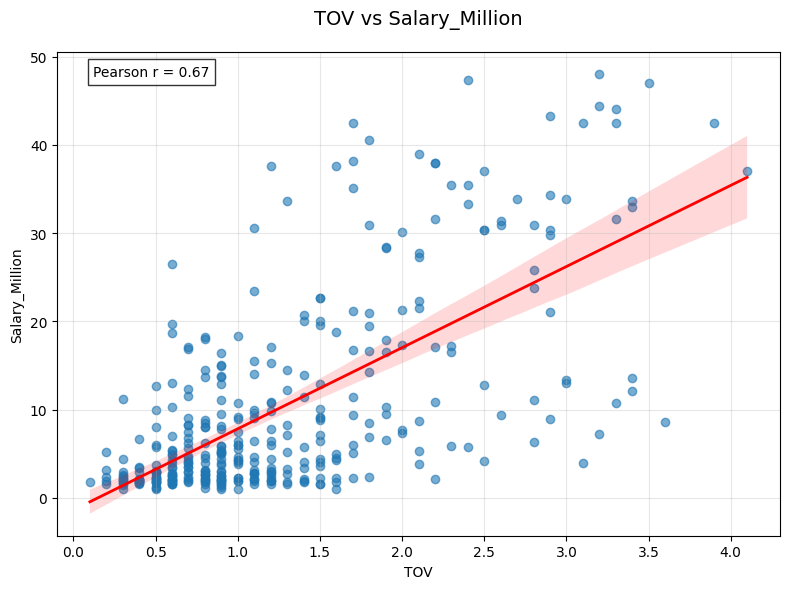

count   365.000
mean     10.566
std       6.911
min       0.900
5%        3.000
10%       3.640
20%       4.980
30%       6.100
40%       7.260
50%       8.900
60%      10.000
70%      11.980
80%      15.900
90%      21.100
95%      24.960
99%      30.460
100%     33.100
max      33.100
Name: PTS, dtype: float64


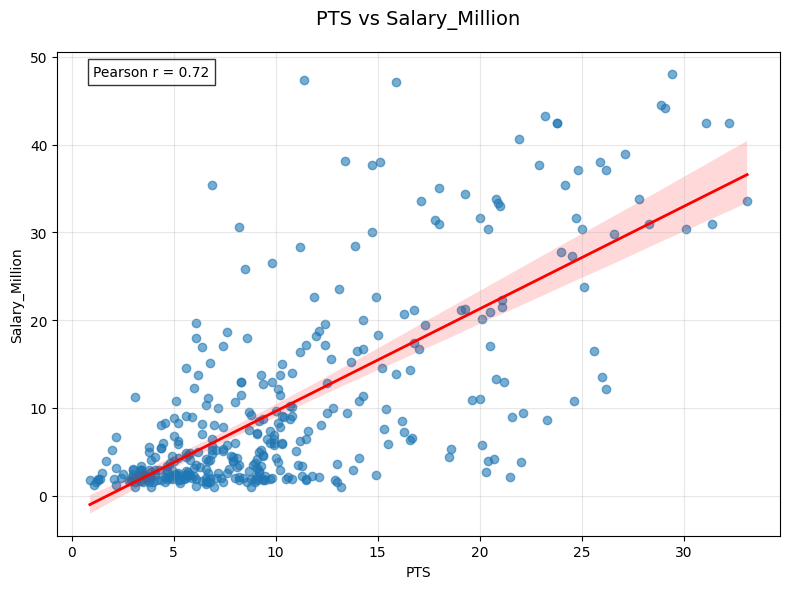

count   365.000
mean     13.897
std       4.584
min       2.700
5%        7.040
10%       8.700
20%      10.280
30%      11.200
40%      12.300
50%      13.300
60%      14.600
70%      15.680
80%      17.400
90%      19.800
95%      22.080
99%      27.344
100%     31.400
max      31.400
Name: PER, dtype: float64


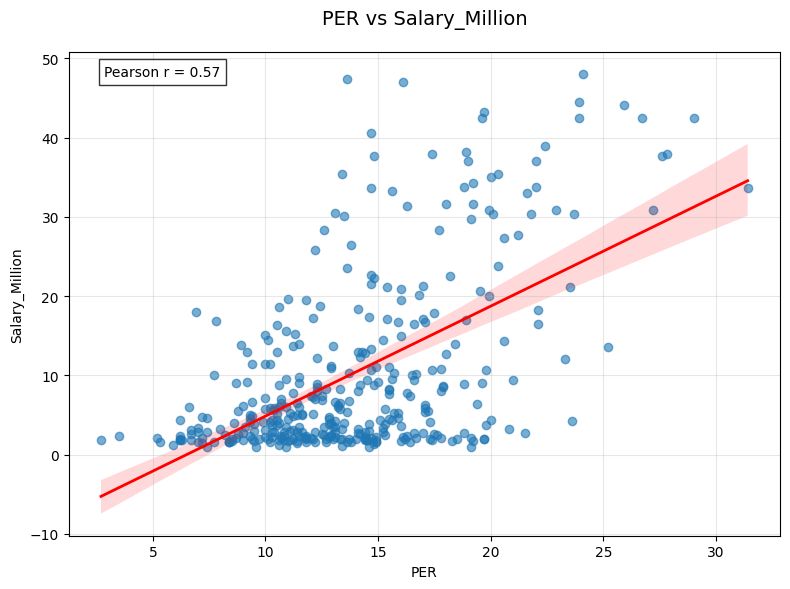

count   365.000
mean     18.650
std       5.715
min       7.400
5%       10.920
10%      12.240
20%      13.800
30%      15.120
40%      16.360
50%      17.700
60%      18.940
70%      20.500
80%      23.520
90%      27.120
95%      29.500
99%      33.480
100%     38.800
max      38.800
Name: USG%, dtype: float64


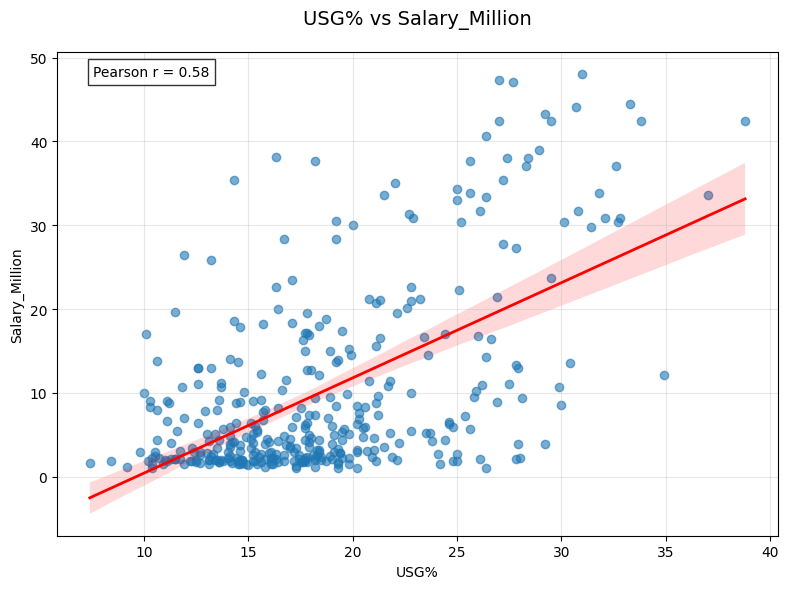

count   365.000
mean      2.931
std       2.552
min      -1.600
5%        0.100
10%       0.300
20%       0.700
30%       1.300
40%       1.800
50%       2.200
60%       2.800
70%       3.700
80%       4.920
90%       6.700
95%       7.880
99%      10.824
100%     12.600
max      12.600
Name: WS, dtype: float64


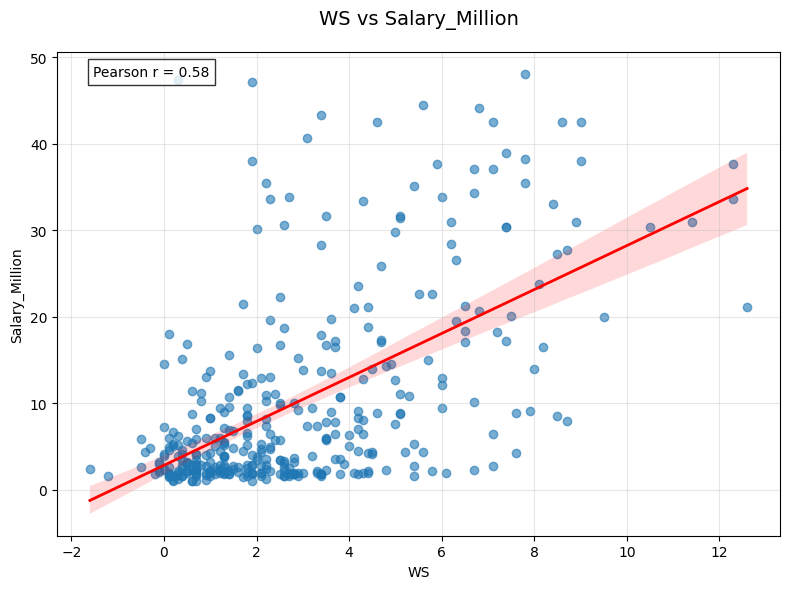

count   365.000
mean     -0.768
std       2.867
min      -9.600
5%       -4.960
10%      -3.900
20%      -3.120
30%      -2.200
40%      -1.500
50%      -1.000
60%      -0.300
70%       0.500
80%       1.100
90%       2.500
95%       4.060
99%       7.372
100%      9.200
max       9.200
Name: BPM, dtype: float64


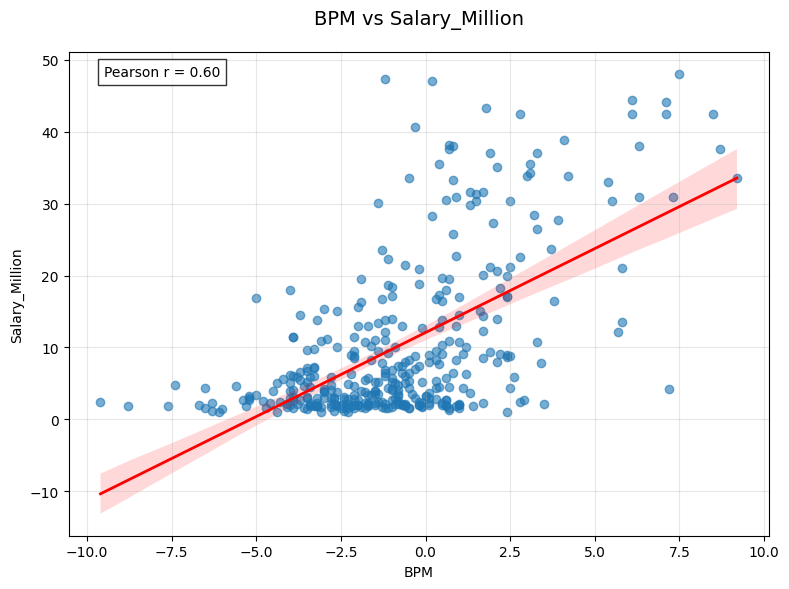

count   365.000
mean      0.698
std       1.282
min      -1.300
5%       -0.600
10%      -0.400
20%      -0.200
30%       0.000
40%       0.100
50%       0.300
60%       0.500
70%       0.900
80%       1.500
90%       2.400
95%       3.480
99%       5.400
100%      6.400
max       6.400
Name: VORP, dtype: float64


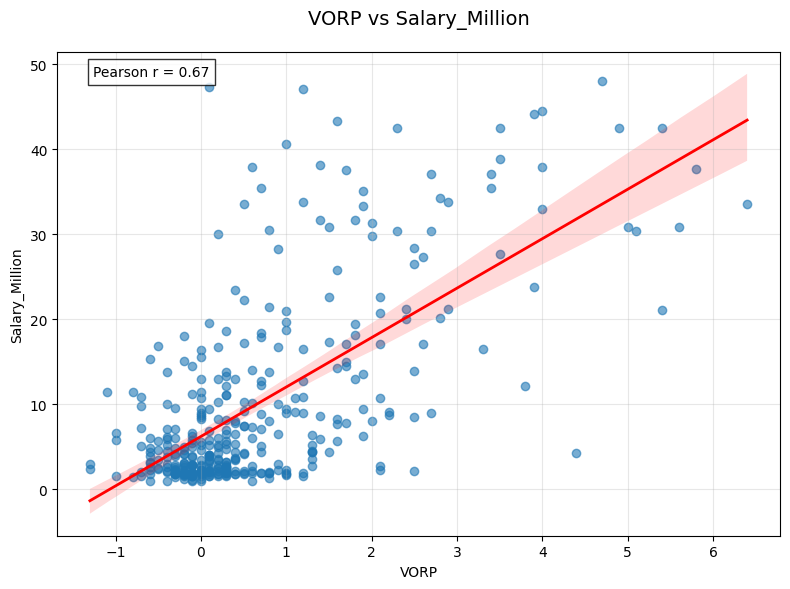

In [57]:
# Önemli değişkenlerin maaşla ilişkisini gösteren grafikler
imp_cols=[6,7,17,18,21,23,24,26,27,28,29] # Önemli sütunların indeksleri
def graph(dataframe, num_col_index):
    # İstatistiksel özet
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
    print(dataframe.iloc[:, num_col_index].describe(quantiles).T)
    # Grafik oluşturma
    num_col_name = dataframe.columns[num_col_index]
    plt.figure(figsize=(8, 6))
    sns.regplot(x=dataframe[num_col_name], y="Salary_Million", data=dataframe,
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red', 'lw':2})
    # Pearson korelasyon katsayısı
    pearson_r = stats.pearsonr(dataframe[num_col_name], dataframe['Salary_Million'])[0]
    plt.text(0.05, 0.95, f'Pearson r = {pearson_r:.2f}',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8))
    plt.title(f'{num_col_name} vs Salary_Million', fontsize=14, pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
# Tüm önemli değişkenler için grafik oluşturma
for col_index in imp_cols:
    graph(data, col_index)



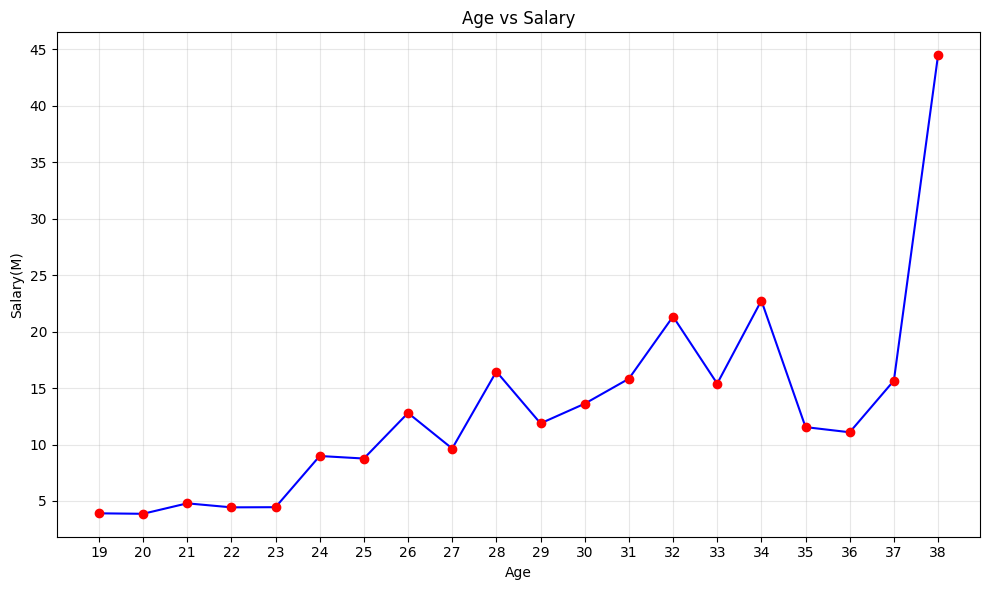

In [58]:
# Yaşa göre ortalama maaş grafiği
age_salary=data.groupby('Age')['Salary_Million'].mean()
plt.figure(figsize=(10, 6))
plt.xticks(range(min(age_salary.index)-1, max(age_salary.index)+1, 1))
plt.plot(age_salary.index, age_salary.values, color='blue', marker='o',markerfacecolor="red",markeredgecolor="red")
plt.xlabel('Age')
plt.ylabel('Salary(M)')
plt.title('Age vs Salary')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Açıklama: Oyuncuların yaşlarına göre ortalama maaş dağılımı gösteriliyor. NBA'de maaşların genellikle hangi yaşlarda zirve yaptığı görülebiliyor.

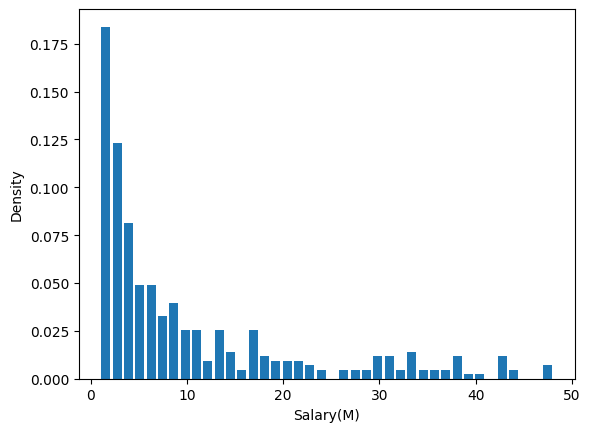

In [59]:
plt.hist(data['Salary_Million'],density=True,bins=40,rwidth=0.8)
plt.xlabel('Salary(M)')
plt.ylabel('Density')
plt.show()

Açıklama: Maaşların dağılımı, 40 farklı gruba ayrılarak histogramla görselleştiriliyor.

[Text(0.5, 0, 'Position'), Text(0, 0.5, 'Salary(M)')]

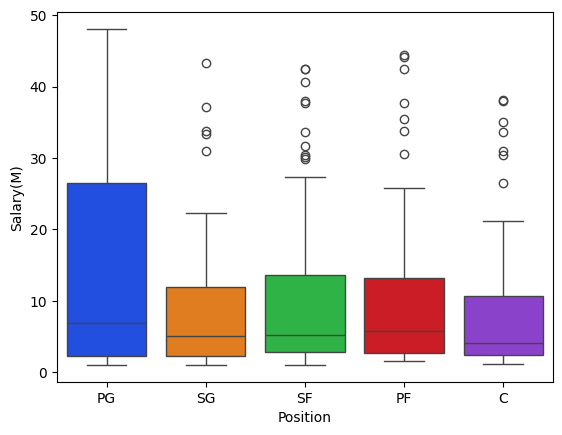

In [60]:
# Pozisyonlara göre maaş dağılımı
position_order = ['PG', 'SG', 'SF', 'PF', 'C']
sns.boxplot(x="Position", y="Salary_Million", data=data,order=position_order,palette=sns.color_palette('bright')).set(
    xlabel='Position',
    ylabel='Salary(M)')

Açıklama: Pozisyonlara göre maaş dağılımı kutu grafiği ile gösteriliyor.

In [61]:
px.pie(data,names='Position',values='Salary_Million',title='Pozisyona Göre Maaş Dağılımı')

Açıklama: Pozisyonlara göre maaş dağılımı pasta grafiği ile gösteriliyor.


*   Pivot pozisyonundaki oyuncuların oranının en düşük seviyede olması dikkat çekici, bu durum modern basketbolda pivotların öneminin azaldığını ortaya koyuyor.


















In [62]:
#Kategorik Değişken İşleme
ohe=pd.get_dummies(data['Position'],drop_first=True)
data=pd.concat([data,ohe],axis=1)
data.drop('Position',axis=1,inplace=True)

In [63]:
data[['PG','SG','SF','PF']].sample(5)

,PG,SG,SF,PF
71,False,False,True,False
321,False,False,True,False
63,False,True,False,False
280,False,False,True,False
303,True,False,False,False


Açıklama: Kategorik pozisyon değişkeni one-hot encoding yöntemiyle sayısal hale getiriliyor

**Makine Öğrenmesi Modelleri**

In [64]:
X=data.drop(['Index','Salary_Million'],axis=1) #Bağımsız Değişkenler
y=data['Salary_Million'] # Bağımlı Değişken

In [65]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)
X_train = x_train.drop(['Player Name','Team'], axis=1)
X_test = x_test.drop(['Player Name','Team'], axis=1)
sc=StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Açıklama: Veri seti eğitim ve test olarak ayrılıyor. Sayısal değişkenler standardizasyon işlemine tabi tutuluyor.

**Lineer Regresyon**

In [66]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  6.275851954149771
R²:  0.7416355185191034


**Destek Vektör Regresyonu (SVR)**

In [67]:
from sklearn.svm import SVR
svr_reg=SVR(kernel="linear")
svr_reg.fit(X_train,y_train)
y_pred=svr_reg.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  6.708449991041803
R²:  0.7047894988707704


**Random Forest Regresyon**

In [68]:
rf=RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(X_train,y_train.ravel())
y_pred=rf.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  5.8469272898714495
R²:  0.775744648772401


**Karar Ağacı Regresyonu**

In [69]:
tree=DecisionTreeRegressor(max_depth=7, criterion="squared_error",random_state=0)
tree.fit(X_train,y_train)
y_pred=tree.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  7.866927847020069
R²:  0.5940264281467763


**KNN Regresyon**

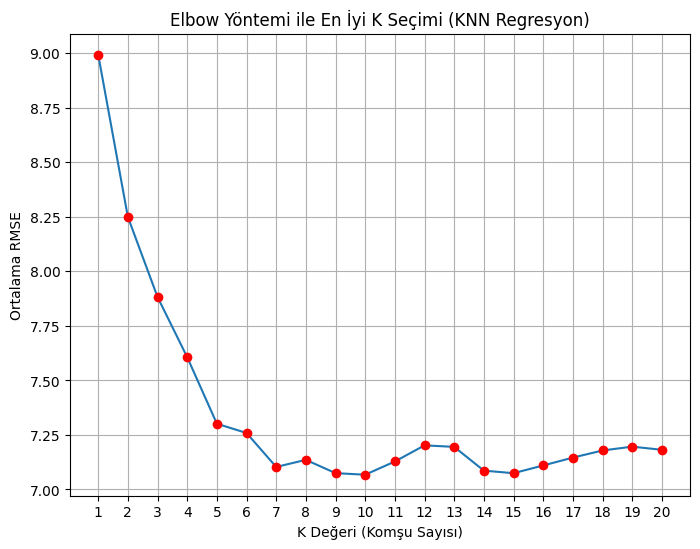

In [70]:
# En iyi K değerini belirlemek için elbow yöntemi
k_values = range(1, 21)
X_cv = X.drop(['Player Name', 'Team'], axis=1)
rmse_scores = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    mse_scores = -cross_val_score(knn,  X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.mean(np.sqrt(mse_scores))
    rmse_scores.append(rmse)

# Elbow grafiğini çiz
plt.figure(figsize=(8, 6))
plt.plot(k_values, rmse_scores, marker='o', markerfacecolor="red",markeredgecolor="red")
plt.xlabel("K Değeri (Komşu Sayısı)")
plt.ylabel("Ortalama RMSE")
plt.title("Elbow Yöntemi ile En İyi K Seçimi (KNN Regresyon)")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [71]:
# En optimal K değeri ile model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
r2=r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  7.181457004681401
R²:  0.5955336567606924


**XGBoost Regresyon**

In [72]:
regressor = XGBRegressor()
regressor.fit(X_train, y_train)
y_pred=regressor.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  7.353560291597655
R²:  0.6452823947188386


Açıklama: XG Boost'un diğer algoritmalardan geride kalması çarpıcı.

**LightGBM Regresyon**

In [73]:
model_LGBM = LGBMRegressor(n_estimators=100, learning_rate=0.1)
model_LGBM.fit(X_train, y_train)
y_pred=model_LGBM.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 273, number of used features: 29
[LightGBM] [Info] Start training from score 9.787802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [74]:
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  5.571699888127474
R²:  0.7963601069929884


**AdaBoost Regresyon**

In [75]:
base = DecisionTreeRegressor(max_depth=5)
model = AdaBoostRegressor(estimator=base, n_estimators=100,random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
r2=r2_score(y_test, y_pred)
print('RMSE: ', rmse)
print('R²: ', r2)

RMSE:  6.276146493046495
R²:  0.7416112667758779


Açıklama: Farklı regresyon algoritmaları denenerek en iyi performans gösteren model belirlenmeye çalışılıyor. Her model için RMSE (Root Mean Squared Error) ve R² skorları hesaplanıyor.

In [76]:
def plot_importance(model, features, num=len(X), importance_type='gain'):
    if hasattr(model, 'booster_'):
        importances = model.booster_.feature_importance(importance_type=importance_type)
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    feature_imp = pd.DataFrame({'Value': importances, 'Feature': features.columns})
    feature_imp["Value"] = feature_imp["Value"] / feature_imp["Value"].sum()
    print(feature_imp.sort_values("Value", ascending=False).round(3))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
        palette=sns.color_palette("bright")
    )
    plt.title('Features')
    plt.tight_layout()
    plt.show()

**Özellik Önemi (Feature Importance)**

    Value Feature
16  0.238     TOV
0   0.181     Age
7   0.137      2P
18  0.069     PTS
2   0.057      MP
3   0.049      FG
21  0.047    USG%
13  0.044     AST
5   0.034      3P
10  0.029      FT
17  0.021    FOUL
22  0.016      WS
12  0.013     TRB
11  0.009     FT%
9   0.009    eFG%
24  0.008    VORP
19  0.007     PER
6   0.007     3P%
23  0.006     BPM
8   0.005     2P%
1   0.005      GP
4   0.004     FG%
20  0.002     TS%
15  0.002     BLK
14  0.001     STL
28  0.000      SG
25  0.000      PF
26  0.000      PG
27  0.000      SF


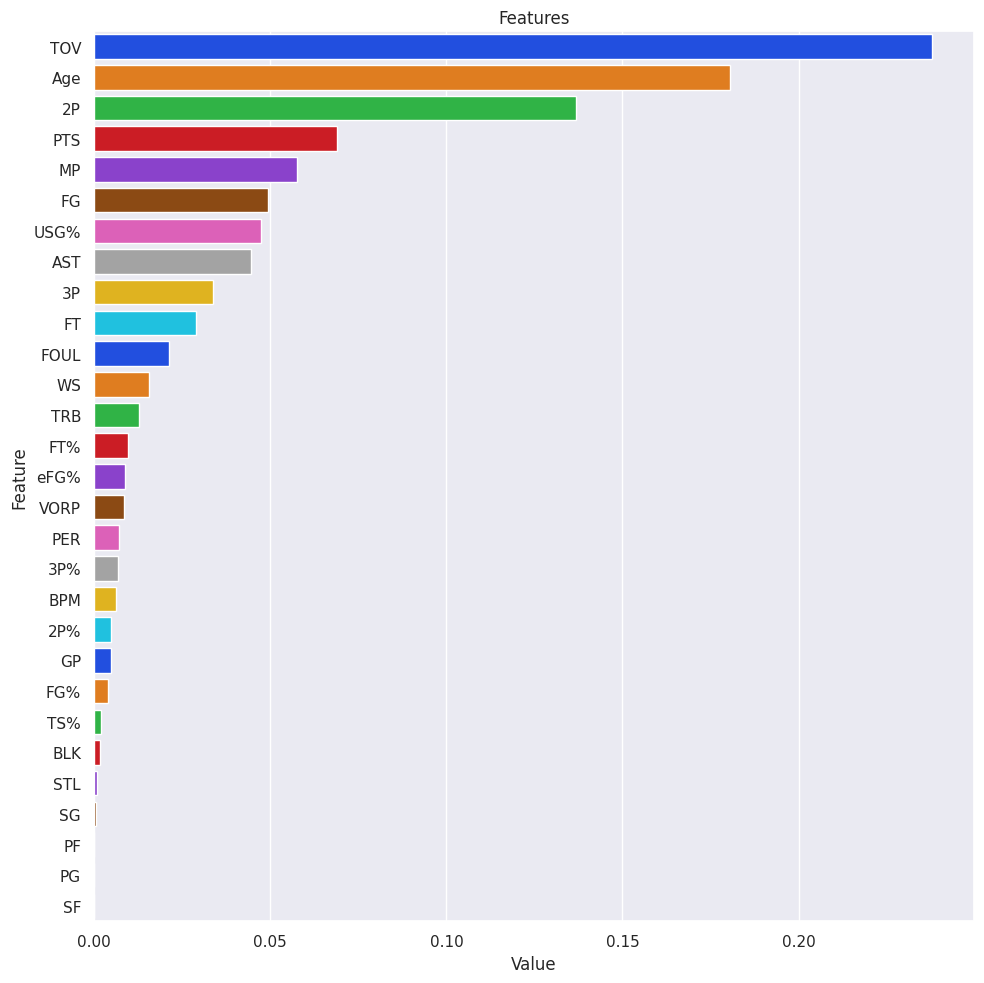

In [77]:
features=X.drop(['Player Name','Team'],axis=1)
plot_importance(model_LGBM, features)

    Value Feature
0   0.165     Age
16  0.122     TOV
18  0.119     PTS
2   0.095      MP
7   0.090      2P
10  0.070      FT
3   0.068      FG
21  0.049    USG%
5   0.034      3P
24  0.022    VORP
13  0.021     AST
11  0.016     FT%
19  0.015     PER
12  0.014     TRB
1   0.013      GP
6   0.012     3P%
17  0.012    FOUL
14  0.011     STL
22  0.010      WS
4   0.008     FG%
23  0.007     BPM
9   0.007    eFG%
20  0.006     TS%
8   0.005     2P%
15  0.004     BLK
26  0.002      PG
25  0.001      PF
28  0.001      SG
27  0.000      SF


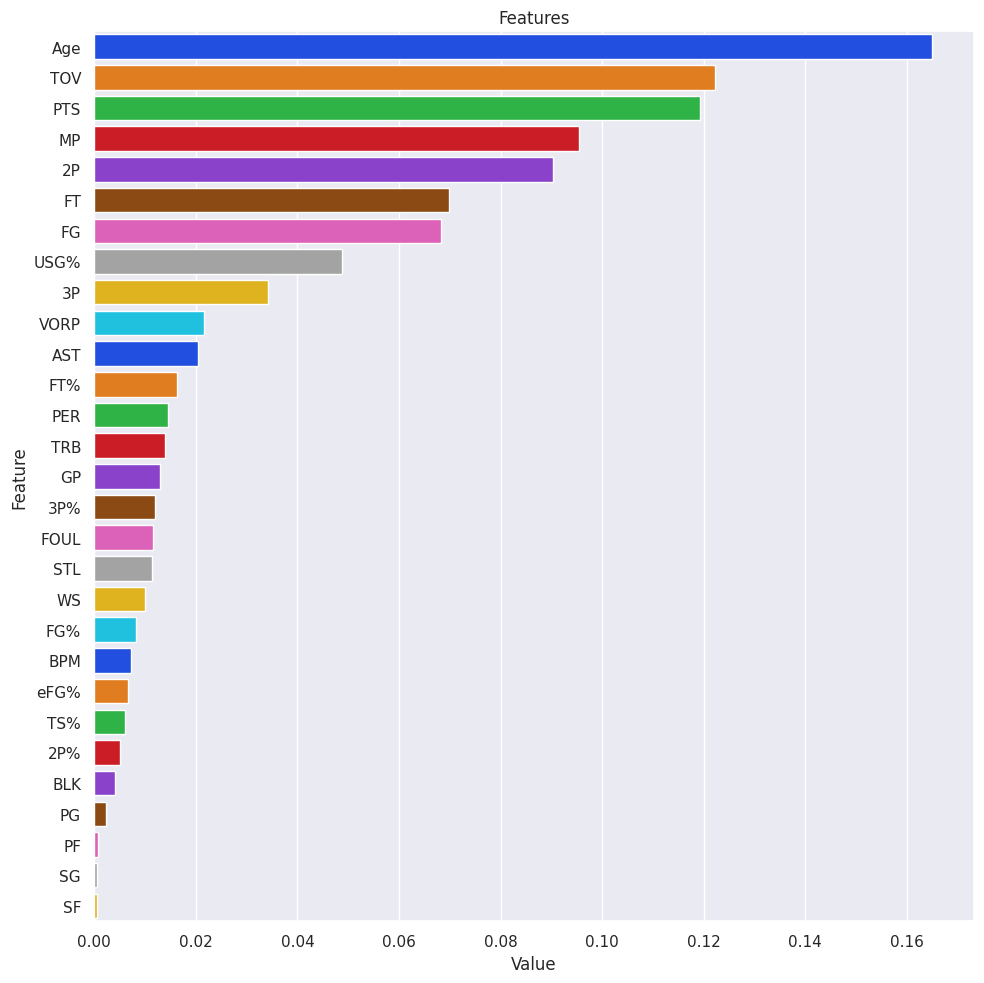

In [78]:
plot_importance(rf, features)

Açıklama: En iyi performans gösteren modellerin (LightGBM ve Random Forest) hangi özelliklere daha çok önem verdiği görselleştiriliyor. Bu, hangi istatistiklerin maaş tahmininde daha etkili olduğunu gösteriyor.


*   Top kaybının olumsuz bir istatistik olmasına rağmen iki modelde de ilk 2 sırada olması ilginç, bu durum yıldız oyuncuların oyunda daha fazla top kullanmalarıyla açıklanabilir.


In [79]:
model_LGBM = LGBMRegressor(n_estimators=100, learning_rate=0.1)
model_LGBM.fit(X_train, y_train)
y_pred_best=model_LGBM.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1387
[LightGBM] [Info] Number of data points in the train set: 273, number of used features: 29
[LightGBM] [Info] Start training from score 9.787802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

**Tahmin Sonuçlarının Değerlendirilmesi**

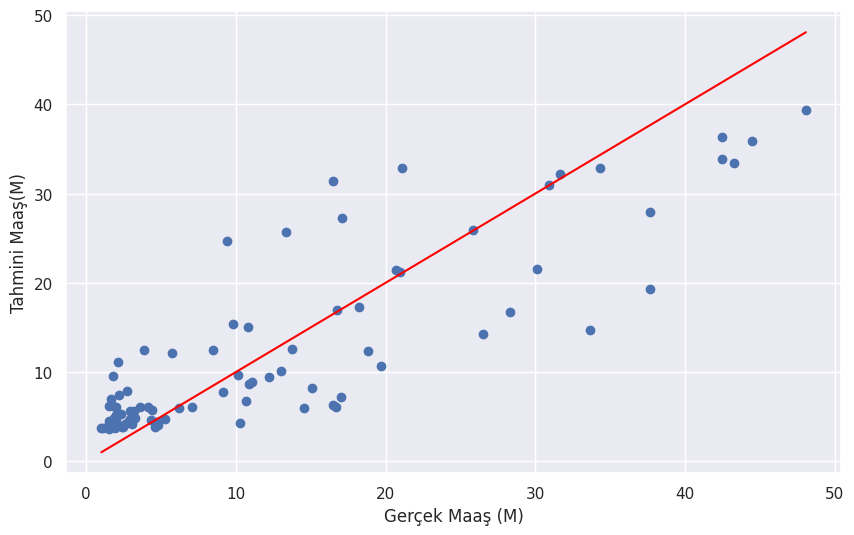

In [80]:
# Tahmin sonuçlarını DataFrame'e kaydetme
predictions = pd.DataFrame({
    'Oyuncu Adı': x_test['Player Name'],
    'Takım': x_test['Team'],
    'Gerçek Maaş': y_test,
    'Tahmini Maaş': y_pred
})
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=1)
plt.xlabel('Gerçek Maaş (M)')
plt.ylabel('Tahmini Maaş(M)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

**Modele Göre Hak Ettiğinden Fazla Maaş Alan Oyuncular Top 5**

In [81]:
predictions['Fark'] = predictions['Gerçek Maaş'] - predictions['Tahmini Maaş']
predictions['Yüzdesel Fark'] = (predictions['Fark'] / predictions['Tahmini Maaş']) * 100
pred_over=predictions.sort_values(by='Yüzdesel Fark', ascending=False)
pred_under=predictions.sort_values(by='Yüzdesel Fark', ascending=True)
pred_over['Yüzdesel Fark']=pred_over['Yüzdesel Fark'].apply(lambda x: f"{x:.2f}%")
pred_over.head()

,Oyuncu Adı,Takım,Gerçek Maaş,Tahmini Maaş,Fark,Yüzdesel Fark
78,Collin Sexton,UTA,16.700,6.098,10.602,173.87%
79,Markelle Fultz,ORL,16.500,6.290,10.210,162.32%
86,Derrick Rose,NYK,14.520,5.991,8.529,142.36%
118,Mo Bamba,LAL/ORL,10.300,4.265,6.035,141.51%
75,Mitchell Robinson,NYK,17.050,7.238,9.812,135.57%


**Modele Göre Hak Ettiğinden Az Maaş Alan Oyuncular Top 5**

In [82]:
pred_under['Yüzdesel Fark']=pred_under['Yüzdesel Fark'].apply(lambda x: f"{x:.2f}%")
pred_under.head()

,Oyuncu Adı,Takım,Gerçek Maaş,Tahmini Maaş,Fark,Yüzdesel Fark
348,Max Strus,MIA,1.820,9.510,-7.690,-80.86%
307,Damion Lee,PHO,2.130,11.081,-8.951,-80.78%
360,Sam Hauser,BOS,1.640,7.002,-5.362,-76.58%
370,Austin Reaves,LAL,1.560,6.232,-4.672,-74.97%
387,Max Christie,LAL,1.020,3.784,-2.764,-73.05%
